## Detecting Depression from Online Text
<br>
[WRITE BLURB ABOUT MOTIVATION FOR PROJECT HERE]
<br><br>
For this project, I used 2 datasets via Kaggle:
<br><br>
- Depression: Twitter Dataset + Feature Extraction, a collection of tweets from Twitter. Each post is labeled with 0 for "not depressed" and 1 for "depressed."
<br><br>
- Sentimental Analysis for Tweets, a collection of tweets from Twitter. Each post is labeled with 0 for "not depressed" and 1 for "depressed."

# EDA

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import contractions

ModuleNotFoundError: No module named 'contractions'

### 1. Read in datasets

In [6]:
df1 = pd.read_csv('Mental-Health-Twitter.csv', index_col=[0])
df2 = pd.read_csv('sentiment_tweets3.csv',index_col=[0])

### 2. Preview contents and gather information about datasets

In [7]:
df1.info

<bound method DataFrame.info of                   post_id                    post_created  \
0      637894677824413696  Sun Aug 30 07:48:37 +0000 2015   
1      637890384576778240  Sun Aug 30 07:31:33 +0000 2015   
2      637749345908051968  Sat Aug 29 22:11:07 +0000 2015   
3      637696421077123073  Sat Aug 29 18:40:49 +0000 2015   
4      637696327485366272  Sat Aug 29 18:40:26 +0000 2015   
...                   ...                             ...   
19995  819336825231773698  Thu Jan 12 00:14:56 +0000 2017   
19996  819334654260080640  Thu Jan 12 00:06:18 +0000 2017   
19997  819334503042871297  Thu Jan 12 00:05:42 +0000 2017   
19998  819334419374899200  Thu Jan 12 00:05:22 +0000 2017   
19999  819334270825197568  Thu Jan 12 00:04:47 +0000 2017   

                                               post_text     user_id  \
0      It's just over 2 years since I was diagnosed w...  1013187241   
1      It's Sunday, I need a break, so I'm planning t...  1013187241   
2      Awake but ti

In [8]:
df2.info

<bound method DataFrame.info of                                        message to examine  \
Index                                                       
106     just had a real good moment. i missssssssss hi...   
217            is reading manga  http://plurk.com/p/mzp1e   
220     @comeagainjen http://twitpic.com/2y2lx - http:...   
288     @lapcat Need to send 'em to my accountant tomo...   
540         ADD ME ON MYSPACE!!!  myspace.com/LookThunder   
...                                                   ...   
802309  No Depression by G Herbo is my mood from now o...   
802310  What do you do when depression succumbs the br...   
802311  Ketamine Nasal Spray Shows Promise Against Dep...   
802312  dont mistake a bad day with depression! everyo...   
802313                                                  0   

        label (depression result)  
Index                              
106                             0  
217                             0  
220                           

### 3. Check for missing data

All 2 datasets do not have missing data.

In [9]:
df1.isnull().all()

post_id         False
post_created    False
post_text       False
user_id         False
followers       False
friends         False
favourites      False
statuses        False
retweets        False
label           False
dtype: bool

In [10]:
df2.isnull().all()

message to examine           False
label (depression result)    False
dtype: bool

### 4. Homogenize column names

Since df2 only has 2 columns 'message to examine' and 'label (depression result)', I only kept the same 2 columns from df1.

In [11]:
# specify columns to keep for d2
df1 = df1[['post_text', 'label']]

# confirm columns kept are the correct ones we want
df1.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [12]:
# standardize column names for df2
df2.columns= ['post_text', 'label']

### 5. Visualize counts of depressive and non-depressive posts

df1 is balanced, but df2 has 4 times the amount of 'non-depressed' posts as it does for 'depressed' posts.

[Text(0.5, 1.0, 'label counts for df2')]

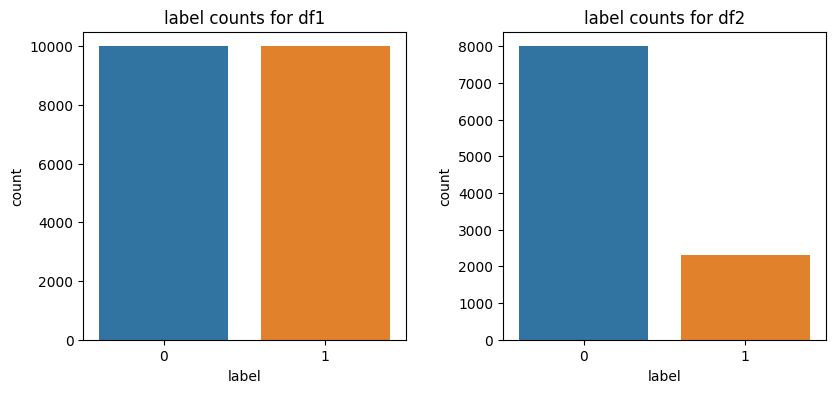

In [13]:
# set up space for figure
fig = plt.figure(figsize=(15,4))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# counts for df2
ax1 = fig.add_subplot(1,3,2)
sns.countplot(x='label', data=df1)
ax1.set(title="label counts for df1")

# counts for df3
ax2 = fig.add_subplot(1,3,3)
sns.countplot(x='label', data=df2)
ax2.set(title="label counts for df2")

In [14]:
# look at actual numbers
df1['label'].value_counts()
df2['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

### 6. Balance df2

Given that we have a large number of data from df1, I used the random undersampling method to undersample the majority class ('non-depressed') by randomly choosing samples without replacement.

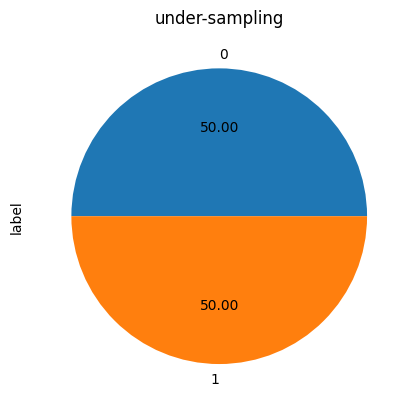

In [15]:
from imblearn.under_sampling import RandomUnderSampler
X = df2.drop(['label'], axis=1)
y = df2['label']

rus = RandomUnderSampler(sampling_strategy='not minority')
X_res, y_res = rus.fit_resample(X, y)

# visualize proportion of labels after balancing
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("under-sampling")

In [16]:
# class distribution
y_res.value_counts()

0    2314
1    2314
Name: label, dtype: int64

In [17]:
# combine columns for d3
df2 = pd.concat([X_res, y_res], axis='columns')

# confirm successful concatenation
df2.head()

# confirm balanced data
df2['label'].value_counts()

0    2314
1    2314
Name: label, dtype: int64

### 7. Combine both dfs

In [18]:
df = pd.concat([df1, df2])

# confirm change
df.shape

(24628, 2)

### 8. Explore number of words in 'depressed' and 'non-depressed' posts

Posts vary in length, so I wanted to see if there were differences in the number of words used in 'depressed' vs 'non-depressed' posts. For simplicity, I assumed that words are separated by spaces.

In [19]:
# split words in 'post-text' and count
df['word_count'] = df['post_text'].apply(lambda x: len(str(x).split()))
df.head()

,post_text,label,word_count
0,It's just over 2 years since I was diagnosed w...,1,26
1,"It's Sunday, I need a break, so I'm planning t...",1,19
2,Awake but tired. I need to sleep but my brain ...,1,13
3,RT @SewHQ: #Retro bears make perfect gifts and...,1,23
4,It’s hard to say whether packing lists are mak...,1,21


Most posts in general tend to be on the shorter end, with depressed posts averaging 15 words versus non-depressed posts averaging 12 words.
<br><br>
The distribution of word counts for non-depressed posts is slightly right-skewed (min: 1, max: 34) and the distribution of word counts for depressed counts is heavily right-skewed (min: 1, max: 92).

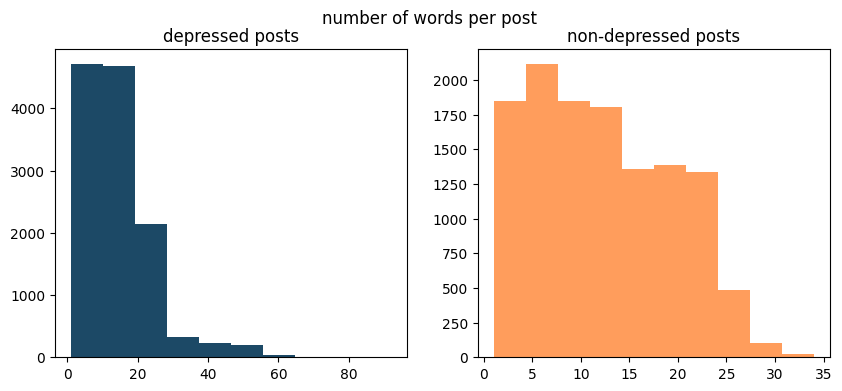

In [20]:
# plot number of words in 'depressed' and 'non-depressed' posts
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

dep_words = df[df['label'] == 1]['word_count']
ax1.hist(dep_words,color='#1c4966')
ax1.set_title('depressed posts')

non_dep_words = df[df['label'] == 0]['word_count']
ax2.hist(non_dep_words, color = '#ff9d5c')
ax2.set_title('non-depressed posts')

fig.suptitle('number of words per post')
plt.show()

In [21]:
print('The minimum number of words in non-depressed posts is: ', non_dep_words.min())
print('The maximum number of words in non-depressed posts is: ', non_dep_words.max())
print('___________________________________________________________')
print('The minimum number of words in depressed posts is: ', dep_words.min())
print('The maximum number of words in non-depressed posts is: ', dep_words.max())
print('___________________________________________________________')
print('The average number of words in non-depressed posts is: ', round(non_dep_words.mean()))
print('The average number of words in depressed posts is: ', round(dep_words.mean()))

The minimum number of words in non-depressed posts is:  1
The maximum number of words in non-depressed posts is:  34
___________________________________________________________
The minimum number of words in depressed posts is:  1
The maximum number of words in non-depressed posts is:  92
___________________________________________________________
The average number of words in non-depressed posts is:  12
The average number of words in depressed posts is:  15


### 9. Split dataset into train and test sets

To avoid data leakage, I split the dataset into train (80%) and test (20%) sets before any pre-processing or normalization/transformation steps.

In [99]:
from sklearn.model_selection import train_test_split

# split into training and testing site with 20% of rows going to testing and 80% going to training
# random state of 10 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(df['post_text'], df['label'], test_size = 0.2, random_state = 10)

print(f"Number of training: {X_train.shape[0]}")
print(f"Number of testing: {X_test.shape[0]}")

Number of training: 19702
Number of testing: 4926


# Pre-process

### 10. Clean text

Prior to building our model, we need to pre-process the text. This involves lemmatizing words and removing stop words, extra white spaces, links, punctuations and special characters.
<br><br>
Since our posts were scraped from the web, there may be some HTML tags embedded in them, which would not be helpful to us. I used Beautiful Soup to remove HTML tags.
<br><br>
I made all the text lowercase and removed punctuations. Stopwords are common words that are not typically useful for NLP. Since we won't be needing them, I also removed them.
<br><br>
Finally, since many words have various forms, I wanted to convert each word to its base form. For this task, the two most common methods are stemming and lemmatization.
<br><br>
Stemming chops off affixes (prefixes/suffixes) of words and can sometimes convert words into something unrecognizable. However, this method tends to be faster. Lemmatization casts words to their root forms and is more involved than stemming since this method needs to know the part of speech for each word, hence would take longer than stemming. 
Since our data isn't horribly large and time/cost are not major concerns, I chose to lemmantization over stemming.

In [152]:
# create stepwise cleaning function
def preprocess(text):
    
    # lowercase text
    text = text.lower()
    
    # strip all excess white space
    text = text.strip()
    
    # strip HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text(separator = ' ')
    
    # remove retweets
    text = re.sub('rt @[\w_]+:','', text)
    
    # remove hyperlinks
    text = re.sub(r'http\S+','', text)
    
    # remove escape sequences
    text = re.sub(r'\n','', text)
    
    # remove punctuations
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    
    return text

In [160]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# remove stopwords
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    text_no_stop = [word for word in word_tokens if word not in stop_words]
    return text_no_stop

In [164]:
from nltk.stem import WordNetLemmatizer

# lemmatize
def lemmatize_text(list_of_tokenized_words):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in list_of_tokenized_words]
    return lemmatized

In [171]:
# put it all together
def final_preprocess(text):
    return preprocess(remove_stopwords(lemmatize_text(text)))
    
# pre-process training data
X_train_clean = [preprocess(text) for text in X_train]
X_train_clean

[' lili and camila in the new riverdale cast poromotional photos ',
 ' rbreich mcconnell one of the worst that sin against america trump is number one sin against america ',
 'i m really tired and feel like i m going to throw up but i m not hot so my nurse won t do anything ugh ',
 'my updated myspace accout love my playlist ',
 ' azfarovski darth zwart zwart means hitam sometimes taking name opposite to your own nature makes you look cool deceivi ',
 ' i thought this was gonna be a legit site hate you bro ',
 ' santa came early hi emeraudetoubia shadowhunters ',
 'have you very had doubts about a particular diagnosis ',
 ' oakland this will be a show that in our entire careers we will never forget scott of pentatonix ptxofficial',
 'n no disrespect to females there s a difference between females n hoes a ho know she a ho ',
 'fear always gets me i get hype as shit everytime it comes on n i usually get another line or verse everytime i hear it',
 'classified election hacking report com

# Text Modeling

### 11. Tokenize text

Prior to running any machine learning models, text data must be converted into numerical feauture vectors.

In [176]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# transform text to feature vectors
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_clean)
print(X_train.shape)

# build dictionary of feature indices to link index value of word to its frequency in training corpus
vectorizer.vocabulary_.get(u'algorithm')

(19702, 25382)


1160

### 12. Calculate TF-IDF

TF-IDF (term frequency-inverse document frequency) divides the count of each word by the total count of words in a document ('TF' part) and then lowers the weight of words that occur most frequently while incrreasing the weight of words that are less frequent ('IDF' part). 

In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer

# fit estimator to data and calculate TF-IDF scores
transformer = TfidfTransformer()
X_train_tfidf = transformer.fit_transform(X_train)
X_train_tfidf.shape

(19702, 25382)

### 13. Create word cloud

Word clouds are popular visualizations for NLP projects since they are a quick way to see the most common words in a document.

### 14. Train classifier

In [183]:
from sklearn.naive_bayes import MultinomialNB

# implement Multinomial Naive Bayes algorithm for classfication
classifier = MultinomialNB().fit(X_train_tfidf, y_train)

### 15. Evaluate performance